In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random
import os

import cv2
from PIL import Image
import PIL.Image
import io
from collections import Counter
from IPython.display import display

from sklearn.metrics import confusion_matrix
import seaborn as sns
#torch:
import torch
import torch.nn as nn
import torch.optim as optim
#from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

#from lime import lime_image
from skimage import segmentation
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = 'drive/MyDrive/MT/archive/Training'
test_dir = 'drive/MyDrive/MT/archive/Testing'

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    #transforms.TrivialAugmentWide(),
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                        std=[0.1768, 0.1768, 0.1768])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                        std=[0.1768, 0.1768, 0.1768])
])


# Validation dataset without augmentation
full_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# Testing dataset
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

#dont run before TA generation:

# Split train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

class weights:

In [ ]:
# Calculate class weights
train_counts = {
    0: 1321,  # Glioma
    1: 1339,  # Meningioma
    2: 1595,  # No Tumor
    3: 1457   # Pituitary
}

total_samples = sum(train_counts.values())  # 5712
class_weights = {class_idx: total_samples / count
                for class_idx, count in train_counts.items()}

print("Class weights:", class_weights)


Class weights: {0: 4.323996971990916, 1: 4.265870052277819, 2: 3.581191222570533, 3: 3.9203843514070007}


normalization:

In [ ]:
# Example of calculating your dataset statistics
def get_dataset_stats(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in dataloader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [ ]:
get_dataset_stats(train_loader)

(tensor([0.1848, 0.1848, 0.1848]), tensor([0.1768, 0.1768, 0.1768]))

make sure labels match:

In [ ]:
import os

# Get class names from the training directory
class_names = sorted(os.listdir(train_dir))

# Print mapping between indices and folder names
print("Class mapping:")
for idx, class_name in enumerate(class_names):
    print(f"Class {idx}: {class_name}")

# Now print distribution with actual class names
train_labels = [label for _, label in train_dataset]
unique_labels, counts = np.unique(train_labels, return_counts=True)
print("\nTraining set class distribution:")
for label, count in zip(unique_labels, counts):
    print(f"{class_names[label]}: {count} samples")

Class mapping:
Class 0: glioma
Class 1: meningioma
Class 2: notumor
Class 3: pituitary

Training set class distribution:
glioma: 1060 samples
meningioma: 1083 samples
notumor: 1250 samples
pituitary: 1176 samples


Saving images

In [ ]:
def save_transformed_images(dataset, transform, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # The dataset's samples are tuples (image, label), with the image already transformed.
    for i, (img_tensor, label) in enumerate(dataset):
        # If `transform` is given, first revert tensor back to PIL and apply the transform
        if transform:
            img = transforms.ToPILImage()(img_tensor)  # Convert tensor back to PIL image
            img = transform(img)  # Apply the transform
        else:
            img = transforms.ToPILImage()(img_tensor)  # No additional transform

        # Save image with class label in the filename
        img.save(os.path.join(output_dir, f'image_{i}_class_{label}.png'))

    print(f"Saved {len(dataset)} images to {output_dir}")

In [ ]:
save_transformed_images(train_dataset, None, 'drive/MyDrive/TA/transformed_train_images')

Saved 2300 images to TA/transformed_train_images


save to drive: (also make folders lol)

In [ ]:
def save_transformed_images(dataset, transform, output_dir):
    """
    Saves transformed images from a dataset, organizing them into subdirectories by class.

    Args:
        dataset: A dataset where each item is a tuple of (image_tensor, label)
        transform: Optional transform to apply to images before saving
        output_dir: Base directory where class subdirectories will be created
    """
    # Create the base output directory
    os.makedirs(output_dir, exist_ok=True)

    # Keep track of images saved per class
    class_counts = {}

    # Create a mapping of all unique classes in the dataset
    unique_classes = set(label.item() if torch.is_tensor(label) else label
                        for _, label in dataset)

    # Create subdirectories for each class
    for class_label in unique_classes:
        class_dir = os.path.join(output_dir, f'class_{class_label}')
        os.makedirs(class_dir, exist_ok=True)
        class_counts[class_label] = 0

    # Save images to their respective class directories
    for i, (img_tensor, label) in enumerate(dataset):
        # Convert tensor label to integer if it's a tensor
        class_label = label.item() if torch.is_tensor(label) else label

        # Get the appropriate directory for this class
        class_dir = os.path.join(output_dir, f'class_{class_label}')

        # Transform the image if needed
        if transform:
            img = transforms.ToPILImage()(img_tensor)
            img = transform(img)
        else:
            img = transforms.ToPILImage()(img_tensor)

        # Save image with class-specific counter
        class_counts[class_label] += 1
        filename = f'image_{class_counts[class_label]}.png'
        img.save(os.path.join(class_dir, filename))

        # Print progress every 100 images
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(dataset)} images")

    # Print summary
    print(f"\nSaved images to {output_dir}")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count} images")


In [ ]:
save_transformed_images(train_dataset, None, 'drive/MyDrive/results/Trivial2/Training4')

Processed 100/5712 images
Processed 200/5712 images
Processed 300/5712 images
Processed 400/5712 images
Processed 500/5712 images
Processed 600/5712 images
Processed 700/5712 images
Processed 800/5712 images
Processed 900/5712 images
Processed 1000/5712 images
Processed 1100/5712 images
Processed 1200/5712 images
Processed 1300/5712 images
Processed 1400/5712 images
Processed 1500/5712 images
Processed 1600/5712 images
Processed 1700/5712 images
Processed 1800/5712 images
Processed 1900/5712 images
Processed 2000/5712 images
Processed 2100/5712 images
Processed 2200/5712 images
Processed 2300/5712 images
Processed 2400/5712 images
Processed 2500/5712 images
Processed 2600/5712 images
Processed 2700/5712 images
Processed 2800/5712 images
Processed 2900/5712 images
Processed 3000/5712 images
Processed 3100/5712 images
Processed 3200/5712 images
Processed 3300/5712 images
Processed 3400/5712 images
Processed 3500/5712 images
Processed 3600/5712 images
Processed 3700/5712 images
Processed 

# <a id='gen'>FINAL MODEL: using class-weights:</a>

In [ ]:
class BrainCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_and_validate(model, train_loader, val_loader, test_loader, class_weights=None, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Calculate class weights if not provided
    if class_weights is None:
        class_weights = calculate_class_weights(train_loader)

    # Convert class weights to tensor
    weight_tensor = torch.FloatTensor([class_weights[i] for i in range(len(class_weights))]).to(device)

    # Initialize weighted loss function
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss/len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')

    # Final Test Phase
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print('\nFinal Test Results:')
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test Accuracy: {100 * test_correct / test_total:.2f}%')

    return history, model

model summary:

In [ ]:
def print_model_summary(model):
    print("Model Structure:")
    print("===============")
    for idx, (name, module) in enumerate(model.named_children()):
        print(f"\nLayer {idx}: {name}")
        print("Parameters:", sum(p.numel() for p in module.parameters()))
        print("Structure:", module)

print_model_summary(model)

Model Structure:

Layer 0: features
Parameters: 23808
Structure: Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout2d(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout2d(p=0.2, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout2d(p=0.2, inplace=False)
)

Layer 1: classifier
Parameters: 2097796
Structure: Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=16384, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
!pip install torchinfo
from torchinfo import summary

# Create model instance
model = BrainCNN()

# Generate summary
# Batch size of 1, 3 channels, 128x128 image size
summary(model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
BrainCNN                                 [1, 4]                    --
├─Sequential: 1-1                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─BatchNorm2d: 2-3                  [1, 16, 64, 64]           32
│    └─Dropout2d: 2-4                    [1, 16, 64, 64]           --
│    └─Conv2d: 2-5                       [1, 32, 32, 32]           4,640
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 32, 32, 32]           64
│    └─Dropout2d: 2-8                    [1, 32, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 16, 16]           18,496
│    └─ReLU: 2-10                        [1, 64, 16, 16]           --
│    └─BatchNorm2d: 2-11                 [1, 64, 16, 16]           128
│    └

In [ ]:
# Create and display summary
summary_display = summary(model, input_size=(1, 3, 128, 128))

# Convert the cell output to an image
plt.figure(figsize=(10, 12))
plt.text(0.1, 0.95, str(summary_display), fontsize=10, family='monospace',
         verticalalignment='top', transform=plt.gca().transAxes)
plt.axis('off')
plt.savefig('model_summary.png', bbox_inches='tight', dpi=300,
            facecolor='white', edgecolor='none')
plt.close()

# <a id='gen'>Model trainings:</a>

BASELINE - FINAL:

In [ ]:
# Train model with weights
model = BrainCNN()
history, trained_model = train_and_validate(model, train_loader, val_loader, test_loader,
                                          class_weights=class_weights)

# Save model with weights and history
save_path = 'drive/MyDrive/results/archive21/base_model_batch32_10_FINAL.pth'
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history,
}, save_path)

Epoch 1:
Train Loss: 0.7677, Train Accuracy: 70.87%
Val Loss: 0.4299, Val Accuracy: 84.34%
Epoch 2:
Train Loss: 0.4787, Train Accuracy: 81.88%
Val Loss: 0.4133, Val Accuracy: 81.63%
Epoch 3:
Train Loss: 0.4070, Train Accuracy: 84.61%
Val Loss: 0.3601, Val Accuracy: 85.30%
Epoch 4:
Train Loss: 0.3380, Train Accuracy: 87.33%
Val Loss: 0.3120, Val Accuracy: 89.06%
Epoch 5:
Train Loss: 0.2919, Train Accuracy: 89.01%
Val Loss: 0.2465, Val Accuracy: 91.25%
Epoch 6:
Train Loss: 0.2466, Train Accuracy: 90.94%
Val Loss: 0.3251, Val Accuracy: 89.06%
Epoch 7:
Train Loss: 0.2011, Train Accuracy: 92.73%
Val Loss: 0.2630, Val Accuracy: 91.25%
Epoch 8:
Train Loss: 0.1839, Train Accuracy: 93.24%
Val Loss: 0.2705, Val Accuracy: 90.99%
Epoch 9:
Train Loss: 0.1664, Train Accuracy: 94.13%
Val Loss: 0.2449, Val Accuracy: 92.48%
Epoch 10:
Train Loss: 0.1309, Train Accuracy: 95.12%
Val Loss: 0.2601, Val Accuracy: 92.39%

Final Test Results:
Test Loss: 0.2570
Test Accuracy: 92.30%


TA:

In [ ]:
class MultiDirDataset(Dataset):
    def __init__(self, base_dir, additional_dirs, transform=None):
        """
        base_dir: path to base training directory in archive
        additional_dirs: list of additional directories to combine
        """
        self.transform = transform

        # Get class names from base directory
        self.classes = sorted(os.listdir(base_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Initialize lists for images and labels
        self.images = []
        self.labels = []

        # First process base directory
        base_images = 0
        for class_name in self.classes:
            class_path = os.path.join(base_dir, class_name)
            if os.path.exists(class_path):
                class_idx = self.class_to_idx[class_name]
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)
                    base_images += 1
        print(f"Added {base_images} images from base directory: {base_dir}")

        # Then process additional directories
        for directory in additional_dirs:
            dir_images = 0
            for class_name in self.classes:
                class_path = os.path.join(directory, class_name)
                if os.path.exists(class_path):
                    class_idx = self.class_to_idx[class_name]
                    for img_name in os.listdir(class_path):
                        img_path = os.path.join(class_path, img_name)
                        self.images.append(img_path)
                        self.labels.append(class_idx)
                        dir_images += 1
            print(f"Added {dir_images} images from: {directory}")

        print(f"Total images in dataset: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

def create_data_loaders(additional_dirs, batch_size=32):
    """
    additional_dirs: list of additional directories to combine with base directory
    """
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                        std=[0.1768, 0.1768, 0.1768]),
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                        std=[0.1768, 0.1768, 0.1768])
    ])

    # Create combined dataset with base directory and additional dirs
    full_dataset = MultiDirDataset(
        base_dir='drive/MyDrive/MT/archive/Training',  # Base directory
        additional_dirs=additional_dirs,
        transform=train_transform
    )

    # Split train/validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create test dataset separately
    test_dataset = datasets.ImageFolder('drive/MyDrive/MT/archive/Testing',
                                      transform=val_test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

# Define your directory combinations (now just the additional dirs, base dir is included automatically)
dirs1 = ['drive/MyDrive/results/Trivial2/Training2']
dirs2 = ['drive/MyDrive/results/Trivial2/Training2',
         'drive/MyDrive/results/Trivial2/Training3']
dirs3 = ['drive/MyDrive/results/Trivial2/Training2',
         'drive/MyDrive/results/Trivial2/Training3',
         'drive/MyDrive/results/Trivial2/Training4']

# Create your three different loader sets
print("\nCreating loader 1 (Base + Training2):")
train_loader_1, val_loader_1, test_loader_1 = create_data_loaders(dirs1)

print("\nCreating loader 2 (Base + Training2 + Training3):")
train_loader_2, val_loader_2, test_loader_2 = create_data_loaders(dirs2)

print("\nCreating loader 3 (Base + Training2 + Training3 + Training4):")
train_loader_3, val_loader_3, test_loader_3 = create_data_loaders(dirs3)

# Verify sizes
print("\nDataset sizes:")
print(f"Loader 1: {len(train_loader_1.dataset)} training samples")
print(f"Loader 2: {len(train_loader_2.dataset)} training samples")
print(f"Loader 3: {len(train_loader_3.dataset)} training samples")


Creating loader 1 (Base + Training2):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/Trivial2/Training2
Total images in dataset: 11424

Creating loader 2 (Base + Training2 + Training3):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/Trivial2/Training2
Added 5712 images from: drive/MyDrive/results/Trivial2/Training3
Total images in dataset: 17136

Creating loader 3 (Base + Training2 + Training3 + Training4):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/Trivial2/Training2
Added 5712 images from: drive/MyDrive/results/Trivial2/Training3
Added 5712 images from: drive/MyDrive/results/Trivial2/Training4
Total images in dataset: 22848

Dataset sizes:
Loader 1: 9139 training samples
Loader 2: 13708 training samples
Loader 3: 18278 training samples


TA (final) 1:

In [ ]:
# Usage example:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_1, val_loader_1, test_loader_1,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/TA_model_final_10.pth')

Epoch 1:
Train Loss: 0.8732, Train Accuracy: 66.16%
Val Loss: 0.5866, Val Accuracy: 74.66%
Epoch 2:
Train Loss: 0.6151, Train Accuracy: 76.04%
Val Loss: 0.4983, Val Accuracy: 80.48%
Epoch 3:
Train Loss: 0.4821, Train Accuracy: 82.42%
Val Loss: 0.3778, Val Accuracy: 85.51%
Epoch 4:
Train Loss: 0.3814, Train Accuracy: 86.09%
Val Loss: 0.3671, Val Accuracy: 85.73%
Epoch 5:
Train Loss: 0.3068, Train Accuracy: 88.45%
Val Loss: 0.3283, Val Accuracy: 87.53%
Epoch 6:
Train Loss: 0.2624, Train Accuracy: 90.90%
Val Loss: 0.3136, Val Accuracy: 89.06%
Epoch 7:
Train Loss: 0.2306, Train Accuracy: 91.92%
Val Loss: 0.2721, Val Accuracy: 89.93%
Epoch 8:
Train Loss: 0.2069, Train Accuracy: 92.76%
Val Loss: 0.2996, Val Accuracy: 90.24%
Epoch 9:
Train Loss: 0.1800, Train Accuracy: 93.88%
Val Loss: 0.3048, Val Accuracy: 90.63%
Epoch 10:
Train Loss: 0.1611, Train Accuracy: 94.41%
Val Loss: 0.2847, Val Accuracy: 90.02%

Final Test Results:
Test Loss: 0.1968
Test Accuracy: 93.82%


In [ ]:
# Usage example:
model = BrainCNN()
# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_2, val_loader_2, test_loader_2,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/TA_model_final_double_10.pth')


Epoch 1:
Train Loss: 0.7966, Train Accuracy: 69.44%
Val Loss: 0.4933, Val Accuracy: 81.04%
Epoch 2:
Train Loss: 0.5469, Train Accuracy: 78.89%
Val Loss: 0.3803, Val Accuracy: 86.14%
Epoch 3:
Train Loss: 0.4186, Train Accuracy: 84.30%
Val Loss: 0.3338, Val Accuracy: 87.05%
Epoch 4:
Train Loss: 0.3378, Train Accuracy: 87.38%
Val Loss: 0.2949, Val Accuracy: 89.50%
Epoch 5:
Train Loss: 0.2886, Train Accuracy: 89.60%
Val Loss: 0.2734, Val Accuracy: 90.34%
Epoch 6:
Train Loss: 0.2543, Train Accuracy: 90.86%
Val Loss: 0.2648, Val Accuracy: 90.29%
Epoch 7:
Train Loss: 0.2246, Train Accuracy: 91.90%
Val Loss: 0.2723, Val Accuracy: 90.81%
Epoch 8:
Train Loss: 0.1952, Train Accuracy: 93.15%
Val Loss: 0.2700, Val Accuracy: 91.13%
Epoch 9:
Train Loss: 0.1808, Train Accuracy: 93.54%
Val Loss: 0.2662, Val Accuracy: 91.37%
Epoch 10:
Train Loss: 0.1856, Train Accuracy: 93.69%
Val Loss: 0.2598, Val Accuracy: 91.60%

Final Test Results:
Test Loss: 0.1733
Test Accuracy: 94.20%


In [ ]:
# Usage example:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_3, val_loader_3, test_loader_3,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/TA_model_final_triple_10.pth')


Epoch 1:
Train Loss: 0.7713, Train Accuracy: 70.24%
Val Loss: 0.4984, Val Accuracy: 81.47%
Epoch 2:
Train Loss: 0.5044, Train Accuracy: 80.97%
Val Loss: 0.3610, Val Accuracy: 86.19%
Epoch 3:
Train Loss: 0.4037, Train Accuracy: 84.84%
Val Loss: 0.2976, Val Accuracy: 88.95%
Epoch 4:
Train Loss: 0.3374, Train Accuracy: 87.72%
Val Loss: 0.2626, Val Accuracy: 90.18%
Epoch 5:
Train Loss: 0.2772, Train Accuracy: 89.74%
Val Loss: 0.2629, Val Accuracy: 89.89%
Epoch 6:
Train Loss: 0.2544, Train Accuracy: 90.98%
Val Loss: 0.2542, Val Accuracy: 90.59%
Epoch 7:
Train Loss: 0.2246, Train Accuracy: 91.83%
Val Loss: 0.2409, Val Accuracy: 91.40%
Epoch 8:
Train Loss: 0.1977, Train Accuracy: 92.89%
Val Loss: 0.2463, Val Accuracy: 91.29%
Epoch 9:
Train Loss: 0.1893, Train Accuracy: 93.47%
Val Loss: 0.2395, Val Accuracy: 91.60%
Epoch 10:
Train Loss: 0.1902, Train Accuracy: 93.25%
Val Loss: 0.2208, Val Accuracy: 92.10%

Final Test Results:
Test Loss: 0.1809
Test Accuracy: 94.43%


GANS:

In [ ]:
class MultiDirDataset(Dataset):
    def __init__(self, base_dir, additional_dirs, transform=None):
        """
        base_dir: path to base training directory in archive
        additional_dirs: list of additional directories to combine
        """
        self.transform = transform

        # Get class names from base directory
        self.classes = sorted(os.listdir(base_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Initialize lists for images and labels
        self.images = []
        self.labels = []

        # First process base directory
        base_images = 0
        for class_name in self.classes:
            class_path = os.path.join(base_dir, class_name)
            if os.path.exists(class_path):
                class_idx = self.class_to_idx[class_name]
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)
                    base_images += 1
        print(f"Added {base_images} images from base directory: {base_dir}")

        # Then process additional directories
        for directory in additional_dirs:
            dir_images = 0
            for class_name in self.classes:
                class_path = os.path.join(directory, class_name)
                if os.path.exists(class_path):
                    class_idx = self.class_to_idx[class_name]
                    for img_name in os.listdir(class_path):
                        img_path = os.path.join(class_path, img_name)
                        self.images.append(img_path)
                        self.labels.append(class_idx)
                        dir_images += 1
            print(f"Added {dir_images} images from: {directory}")

        print(f"Total images in dataset: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

def create_data_loaders(additional_dirs, batch_size=32):
    """
    additional_dirs: list of additional directories to combine with base directory
    """
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                        std=[0.1768, 0.1768, 0.1768]),
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                        std=[0.1768, 0.1768, 0.1768]),
    ])

    # Create combined dataset with base directory and additional dirs
    full_dataset = MultiDirDataset(
        base_dir='drive/MyDrive/MT/archive/Training',  # Base directory
        additional_dirs=additional_dirs,
        transform=train_transform,
    )

    # Split train/validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create test dataset separately
    test_dataset = datasets.ImageFolder('drive/MyDrive/MT/archive/Testing',
                                      transform=val_test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

# Define your directory combinations (now just the additional dirs, base dir is included automatically)
dirs1 = ['drive/MyDrive/results/GAN_pix_2/Training2']
dirs2 = ['drive/MyDrive/results/GAN_pix_2/Training2',
         'drive/MyDrive/results/GAN_pix_2/Training3']
dirs3 = ['drive/MyDrive/results/GAN_pix_2/Training2',
         'drive/MyDrive/results/GAN_pix_2/Training3',
         'drive/MyDrive/results/GAN_pix_2/Training4']

# Create your three different loader sets
print("\nCreating loader 1 (Base + Training2):")
train_loader_1, val_loader_1, test_loader_1 = create_data_loaders(dirs1)

print("\nCreating loader 2 (Base + Training2 + Training3):")
train_loader_2, val_loader_2, test_loader_2 = create_data_loaders(dirs2)

print("\nCreating loader 3 (Base + Training2 + Training3 + Training4):")
train_loader_3, val_loader_3, test_loader_3 = create_data_loaders(dirs3)

# Verify sizes
print("\nDataset sizes:")
print(f"Loader 1: {len(train_loader_1.dataset)} training samples")
print(f"Loader 2: {len(train_loader_2.dataset)} training samples")
print(f"Loader 3: {len(train_loader_3.dataset)} training samples")


Creating loader 1 (Base + Training2):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training2
Total images in dataset: 11424

Creating loader 2 (Base + Training2 + Training3):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training2
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training3
Total images in dataset: 17136

Creating loader 3 (Base + Training2 + Training3 + Training4):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training2
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training3
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training4
Total images in dataset: 22848

Dataset sizes:
Loader 1: 9139 training samples
Loader 2: 13708 training samples
Loader 3: 18278 training samples


In [ ]:
# Usage example:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_1, val_loader_1, test_loader_1,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/gan_model_final_10.pth')

Epoch 1:
Train Loss: 0.6578, Train Accuracy: 74.91%
Val Loss: 0.3766, Val Accuracy: 84.16%
Epoch 2:
Train Loss: 0.3493, Train Accuracy: 87.24%
Val Loss: 0.2009, Val Accuracy: 93.30%
Epoch 3:
Train Loss: 0.2400, Train Accuracy: 91.27%
Val Loss: 0.1628, Val Accuracy: 94.44%
Epoch 4:
Train Loss: 0.1724, Train Accuracy: 93.64%
Val Loss: 0.1035, Val Accuracy: 96.37%
Epoch 5:
Train Loss: 0.1622, Train Accuracy: 94.29%
Val Loss: 0.0946, Val Accuracy: 96.67%
Epoch 6:
Train Loss: 0.1125, Train Accuracy: 96.18%
Val Loss: 0.0936, Val Accuracy: 97.46%
Epoch 7:
Train Loss: 0.0964, Train Accuracy: 96.62%
Val Loss: 0.0804, Val Accuracy: 97.46%
Epoch 8:
Train Loss: 0.1003, Train Accuracy: 96.43%
Val Loss: 0.0807, Val Accuracy: 97.59%
Epoch 9:
Train Loss: 0.0847, Train Accuracy: 97.08%
Val Loss: 0.0625, Val Accuracy: 97.72%
Epoch 10:
Train Loss: 0.0837, Train Accuracy: 97.14%
Val Loss: 0.0661, Val Accuracy: 97.94%

Final Test Results:
Test Loss: 0.2170
Test Accuracy: 93.14%


In [ ]:
# Usage example:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_2, val_loader_2, test_loader_2,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/gan_model_final_double_10.pth')

Epoch 1:
Train Loss: 0.4658, Train Accuracy: 82.91%
Val Loss: 0.1532, Val Accuracy: 95.25%
Epoch 2:
Train Loss: 0.2052, Train Accuracy: 92.79%
Val Loss: 0.0955, Val Accuracy: 96.76%
Epoch 3:
Train Loss: 0.1411, Train Accuracy: 95.50%
Val Loss: 0.0681, Val Accuracy: 97.72%
Epoch 4:
Train Loss: 0.1109, Train Accuracy: 96.08%
Val Loss: 0.0599, Val Accuracy: 97.96%
Epoch 5:
Train Loss: 0.0928, Train Accuracy: 96.89%
Val Loss: 0.0573, Val Accuracy: 98.07%
Epoch 6:
Train Loss: 0.0841, Train Accuracy: 97.20%
Val Loss: 0.0384, Val Accuracy: 98.57%
Epoch 7:
Train Loss: 0.0769, Train Accuracy: 97.40%
Val Loss: 0.0553, Val Accuracy: 98.48%
Epoch 8:
Train Loss: 0.0672, Train Accuracy: 97.62%
Val Loss: 0.0838, Val Accuracy: 97.67%
Epoch 9:
Train Loss: 0.0700, Train Accuracy: 97.78%
Val Loss: 0.0466, Val Accuracy: 98.40%
Epoch 10:
Train Loss: 0.0680, Train Accuracy: 97.80%
Val Loss: 0.0363, Val Accuracy: 98.80%

Final Test Results:
Test Loss: 0.1994
Test Accuracy: 93.82%


In [ ]:
# Usage example:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_3, val_loader_3, test_loader_3,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/gan_model_final_triple_history_10.pth')

Epoch 1:
Train Loss: 0.3731, Train Accuracy: 86.57%
Val Loss: 0.1060, Val Accuracy: 96.39%
Epoch 2:
Train Loss: 0.1541, Train Accuracy: 94.61%
Val Loss: 0.0571, Val Accuracy: 98.12%
Epoch 3:
Train Loss: 0.1096, Train Accuracy: 96.39%
Val Loss: 0.0589, Val Accuracy: 97.94%
Epoch 4:
Train Loss: 0.1039, Train Accuracy: 96.45%
Val Loss: 0.0692, Val Accuracy: 97.48%
Epoch 5:
Train Loss: 0.0887, Train Accuracy: 97.22%
Val Loss: 0.0397, Val Accuracy: 98.58%
Epoch 6:
Train Loss: 0.0729, Train Accuracy: 97.49%
Val Loss: 0.0540, Val Accuracy: 98.10%
Epoch 7:
Train Loss: 0.0681, Train Accuracy: 97.79%
Val Loss: 0.0310, Val Accuracy: 98.82%
Epoch 8:
Train Loss: 0.0600, Train Accuracy: 98.05%
Val Loss: 0.0397, Val Accuracy: 98.62%
Epoch 9:
Train Loss: 0.0595, Train Accuracy: 98.15%
Val Loss: 0.0460, Val Accuracy: 98.53%
Epoch 10:
Train Loss: 0.0689, Train Accuracy: 97.78%
Val Loss: 0.0365, Val Accuracy: 98.84%

Final Test Results:
Test Loss: 0.2365
Test Accuracy: 92.30%


COMBINED GAN+ AUG:

In [ ]:
def create_data_loaders(additional_dirs, use_trivial=False, batch_size=32):
    # Define transforms
    transform_list = [
        transforms.Resize((128, 128))
    ]
    if use_trivial:
        transform_list.append(transforms.TrivialAugmentWide())
    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                           std=[0.1768, 0.1768, 0.1768])
    ])
    train_transform = transforms.Compose(transform_list)

    val_test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1848, 0.1848, 0.1848],
                           std=[0.1768, 0.1768, 0.1768])
    ])

    # Create dataset without transforms first
    full_dataset = MultiDirDataset(
        base_dir='drive/MyDrive/MT/archive/Training',
        additional_dirs=additional_dirs,
        transform=None  # No transform initially
    )

    # Split first
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Then apply appropriate transforms to each subset
    train_dataset = TransformSubset(train_dataset, train_transform)
    val_dataset = TransformSubset(val_dataset, val_test_transform)

    # Create test dataset separately
    test_dataset = datasets.ImageFolder('drive/MyDrive/MT/archive/Testing',
                                      transform=val_test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

# We need this helper class to apply transforms after splitting
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Define your directory combinations (now just the additional dirs, base dir is included automatically)
dirs1 = ['drive/MyDrive/results/GAN_pix_2/Training2']
dirs2 = ['drive/MyDrive/results/GAN_pix_2/Training2',
         'drive/MyDrive/results/GAN_pix_2/Training3']
dirs3 = ['drive/MyDrive/results/GAN_pix_2/Training2',
         'drive/MyDrive/results/GAN_pix_2/Training3',
         'drive/MyDrive/results/GAN_pix_2/Training4']

# Create your three different loader sets
print("\nCreating loader 1 (Base + Training2):")
train_loader_1, val_loader_1, test_loader_1 = create_data_loaders(dirs1)

print("\nCreating loader 2 (Base + Training2 + Training3):")
train_loader_2, val_loader_2, test_loader_2 = create_data_loaders(dirs2)

print("\nCreating loader 3 (Base + Training2 + Training3 + Training4):")
train_loader_3, val_loader_3, test_loader_3 = create_data_loaders(dirs3)

# Verify sizes
print("\nDataset sizes:")
print(f"Loader 1: {len(train_loader_1.dataset)} training samples")
print(f"Loader 2: {len(train_loader_2.dataset)} training samples")
print(f"Loader 3: {len(train_loader_3.dataset)} training samples")


Creating loader 1 (Base + Training2):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training2
Total images in dataset: 11424

Creating loader 2 (Base + Training2 + Training3):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training2
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training3
Total images in dataset: 17136

Creating loader 3 (Base + Training2 + Training3 + Training4):
Added 5712 images from base directory: drive/MyDrive/MT/archive/Training
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training2
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training3
Added 5712 images from: drive/MyDrive/results/GAN_pix_2/Training4
Total images in dataset: 22848

Dataset sizes:
Loader 1: 9139 training samples
Loader 2: 13708 training samples
Loader 3: 18278 training samples


combined 1:

In [ ]:
# Usage example:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_1, val_loader_1, test_loader_1,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/combined_model_FINAL_10.pth') #put in archive21

Epoch 1:
Train Loss: 0.6497, Train Accuracy: 75.65%
Val Loss: 0.2850, Val Accuracy: 88.93%
Epoch 2:
Train Loss: 0.3517, Train Accuracy: 87.11%
Val Loss: 0.2706, Val Accuracy: 88.45%
Epoch 3:
Train Loss: 0.2374, Train Accuracy: 91.63%
Val Loss: 0.1296, Val Accuracy: 95.27%
Epoch 4:
Train Loss: 0.1780, Train Accuracy: 93.99%
Val Loss: 0.1144, Val Accuracy: 96.15%
Epoch 5:
Train Loss: 0.1475, Train Accuracy: 95.03%
Val Loss: 0.0835, Val Accuracy: 96.72%
Epoch 6:
Train Loss: 0.1137, Train Accuracy: 95.98%
Val Loss: 0.0753, Val Accuracy: 97.64%
Epoch 7:
Train Loss: 0.1107, Train Accuracy: 95.89%
Val Loss: 0.0847, Val Accuracy: 97.16%
Epoch 8:
Train Loss: 0.1089, Train Accuracy: 96.25%
Val Loss: 0.0802, Val Accuracy: 97.64%
Epoch 9:
Train Loss: 0.1064, Train Accuracy: 96.40%
Val Loss: 0.0902, Val Accuracy: 97.51%
Epoch 10:
Train Loss: 0.0914, Train Accuracy: 97.11%
Val Loss: 0.0854, Val Accuracy: 97.81%

Final Test Results:
Test Loss: 0.2185
Test Accuracy: 93.90%


combined 2:

In [ ]:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_2, val_loader_2, test_loader_2,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/combined_model_FINAL_double_10.pth')

Epoch 1:
Train Loss: 0.4988, Train Accuracy: 81.63%
Val Loss: 0.1522, Val Accuracy: 95.22%
Epoch 2:
Train Loss: 0.2109, Train Accuracy: 92.46%
Val Loss: 0.0756, Val Accuracy: 96.94%
Epoch 3:
Train Loss: 0.1487, Train Accuracy: 94.81%
Val Loss: 0.0671, Val Accuracy: 98.10%
Epoch 4:
Train Loss: 0.1030, Train Accuracy: 96.40%
Val Loss: 0.0512, Val Accuracy: 98.02%
Epoch 5:
Train Loss: 0.0941, Train Accuracy: 97.01%
Val Loss: 0.0571, Val Accuracy: 98.16%
Epoch 6:
Train Loss: 0.0898, Train Accuracy: 97.03%
Val Loss: 0.0378, Val Accuracy: 98.86%
Epoch 7:
Train Loss: 0.0754, Train Accuracy: 97.45%
Val Loss: 0.0450, Val Accuracy: 98.45%
Epoch 8:
Train Loss: 0.0631, Train Accuracy: 97.86%
Val Loss: 0.0365, Val Accuracy: 98.48%
Epoch 9:
Train Loss: 0.0674, Train Accuracy: 97.78%
Val Loss: 0.0356, Val Accuracy: 98.75%
Epoch 10:
Train Loss: 0.0675, Train Accuracy: 97.80%
Val Loss: 0.0328, Val Accuracy: 98.83%

Final Test Results:
Test Loss: 0.2105
Test Accuracy: 93.59%


combined 3:

In [ ]:
model = BrainCNN()

# Or let the function calculate them automatically:
history, trained_model = train_and_validate(model, train_loader_3, val_loader_3, test_loader_3,
                                          class_weights=class_weights)

# Save both model and history
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'history': history
}, 'drive/MyDrive/results/archive21/combined_model_FINAL_triple_10.pth')

Epoch 1:
Train Loss: 0.4758, Train Accuracy: 82.45%
Val Loss: 0.1489, Val Accuracy: 94.73%
Epoch 2:
Train Loss: 0.1836, Train Accuracy: 93.66%
Val Loss: 0.0586, Val Accuracy: 98.07%
Epoch 3:
Train Loss: 0.1275, Train Accuracy: 95.60%
Val Loss: 0.0435, Val Accuracy: 98.36%
Epoch 4:
Train Loss: 0.1136, Train Accuracy: 96.09%
Val Loss: 0.0529, Val Accuracy: 98.01%
Epoch 5:
Train Loss: 0.0948, Train Accuracy: 96.74%
Val Loss: 0.0369, Val Accuracy: 98.75%
Epoch 6:
Train Loss: 0.0720, Train Accuracy: 97.60%
Val Loss: 0.0294, Val Accuracy: 99.04%
Epoch 7:
Train Loss: 0.0684, Train Accuracy: 97.73%
Val Loss: 0.0277, Val Accuracy: 98.88%
Epoch 8:
Train Loss: 0.0701, Train Accuracy: 97.87%
Val Loss: 0.0366, Val Accuracy: 98.77%
Epoch 9:
Train Loss: 0.0630, Train Accuracy: 98.02%
Val Loss: 0.0299, Val Accuracy: 98.95%
Epoch 10:
Train Loss: 0.0598, Train Accuracy: 98.13%
Val Loss: 0.0347, Val Accuracy: 98.71%

Final Test Results:
Test Loss: 0.2339
Test Accuracy: 93.21%


not very 'nicely coded' training plots:

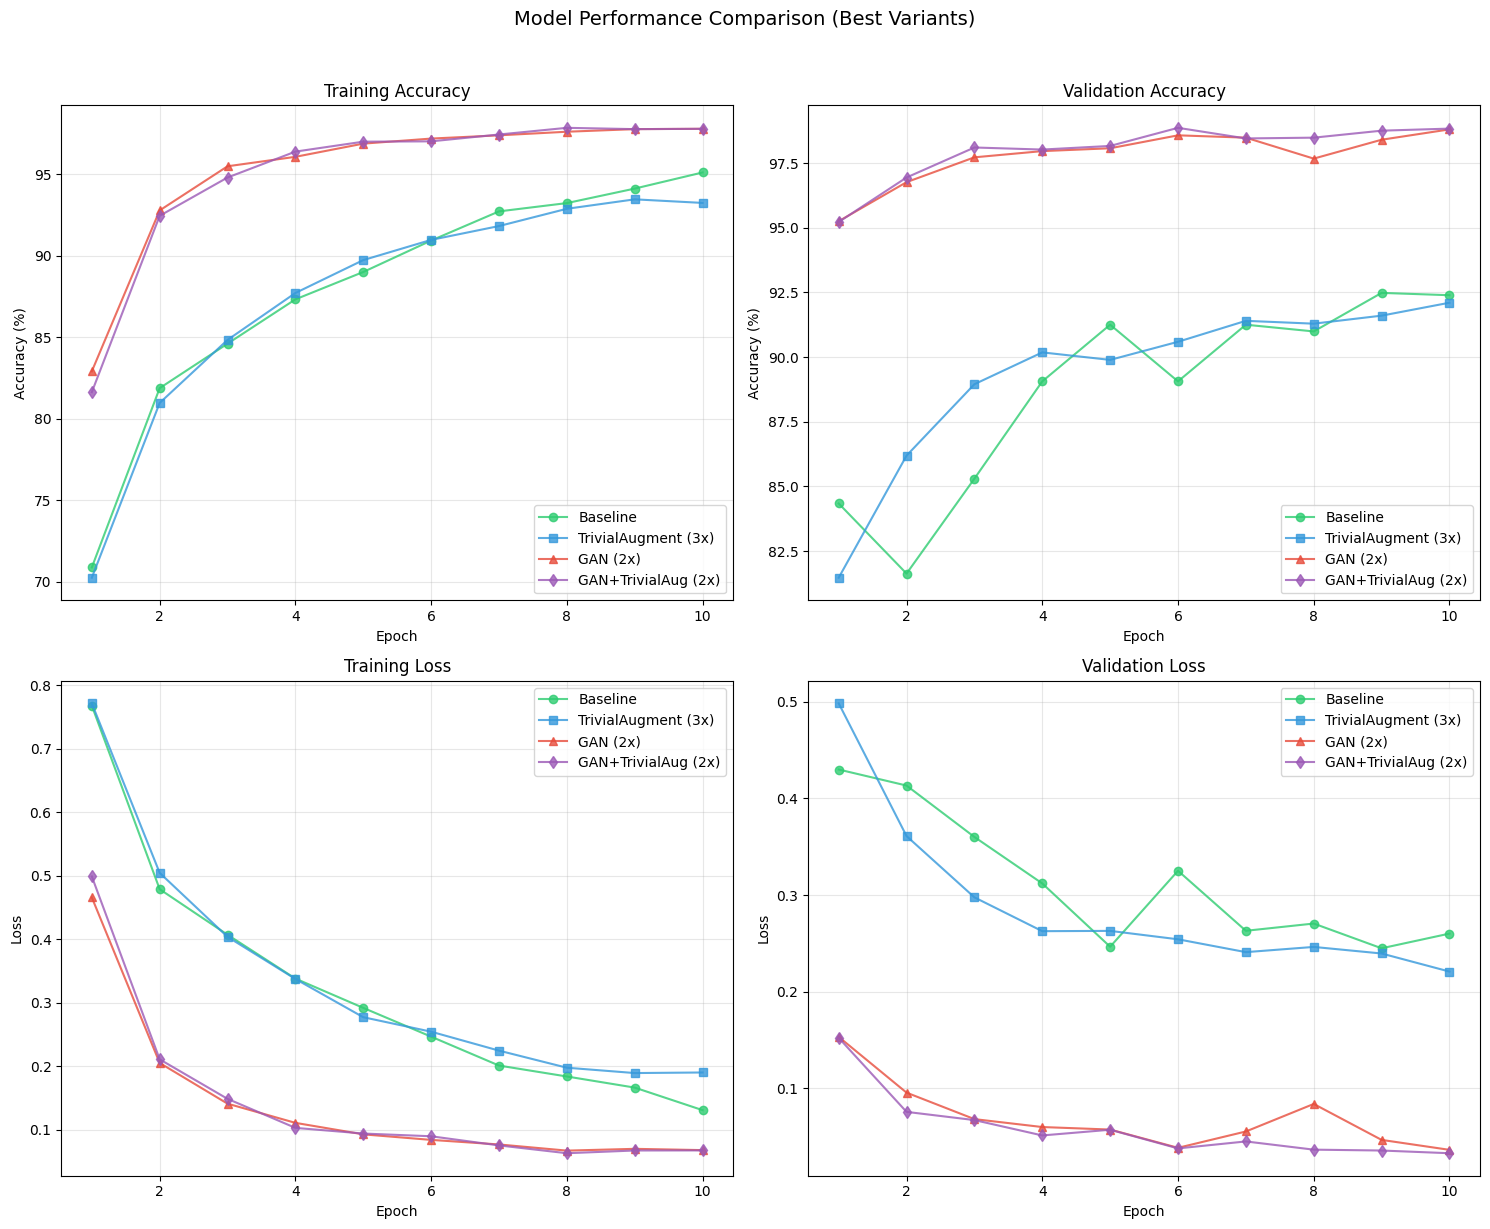

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for each model (using best performing variants)
epochs = range(1, 11)

# Baseline model
baseline = {
    'train_acc': [70.87, 81.88, 84.61, 87.33, 89.01, 90.94, 92.73, 93.24, 94.13, 95.12],
    'val_acc': [84.34, 81.63, 85.30, 89.06, 91.25, 89.06, 91.25, 90.99, 92.48, 92.39],
    'train_loss': [0.7677, 0.4787, 0.4070, 0.3380, 0.2919, 0.2466, 0.2011, 0.1839, 0.1664, 0.1309],
    'val_loss': [0.4299, 0.4133, 0.3601, 0.3120, 0.2465, 0.3251, 0.2630, 0.2705, 0.2449, 0.2601]
}

# TrivialAugment (Triple - best performing version)
trivial_triple = {
    'train_acc': [70.24, 80.97, 84.84, 87.72, 89.74, 90.98, 91.83, 92.89, 93.47, 93.25],
    'val_acc': [81.47, 86.19, 88.95, 90.18, 89.89, 90.59, 91.40, 91.29, 91.60, 92.10],
    'train_loss': [0.7713, 0.5044, 0.4037, 0.3374, 0.2772, 0.2544, 0.2246, 0.1977, 0.1893, 0.1902],
    'val_loss': [0.4984, 0.3610, 0.2976, 0.2626, 0.2629, 0.2542, 0.2409, 0.2463, 0.2395, 0.2208]
}

# GAN (Double - best performing version)
gan_double = {
    'train_acc': [82.91, 92.79, 95.50, 96.08, 96.89, 97.20, 97.40, 97.62, 97.78, 97.80],
    'val_acc': [95.25, 96.76, 97.72, 97.96, 98.07, 98.57, 98.48, 97.67, 98.40, 98.80],
    'train_loss': [0.4658, 0.2052, 0.1411, 0.1109, 0.0928, 0.0841, 0.0769, 0.0672, 0.0700, 0.0680],
    'val_loss': [0.1532, 0.0955, 0.0681, 0.0599, 0.0573, 0.0384, 0.0553, 0.0838, 0.0466, 0.0363]
}

# GAN + TrivialAugment (Double - best performing combined)
combined_double = {
    'train_acc': [81.63, 92.46, 94.81, 96.40, 97.01, 97.03, 97.45, 97.86, 97.78, 97.80],
    'val_acc': [95.22, 96.94, 98.10, 98.02, 98.16, 98.86, 98.45, 98.48, 98.75, 98.83],
    'train_loss': [0.4988, 0.2109, 0.1487, 0.1030, 0.0941, 0.0898, 0.0754, 0.0631, 0.0674, 0.0675],
    'val_loss': [0.1522, 0.0756, 0.0671, 0.0512, 0.0571, 0.0378, 0.0450, 0.0365, 0.0356, 0.0328]
}

# Set style
sns.set_palette("husl")
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
epochs = range(1, 11)

# Create 2x2 subplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison (Best Variants)', fontsize=14, y=1.02)

# Training Accuracy
ax1.plot(epochs, baseline['train_acc'], '-o', label='Baseline', color=colors[0], alpha=0.8)
ax1.plot(epochs, trivial_triple['train_acc'], '-s', label='TrivialAugment (3x)', color=colors[1], alpha=0.8)
ax1.plot(epochs, gan_double['train_acc'], '-^', label='GAN (2x)', color=colors[2], alpha=0.8)
ax1.plot(epochs, combined_double['train_acc'], '-d', label='GAN+TrivialAug (2x)', color=colors[3], alpha=0.8)
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Validation Accuracy
ax2.plot(epochs, baseline['val_acc'], '-o', label='Baseline', color=colors[0], alpha=0.8)
ax2.plot(epochs, trivial_triple['val_acc'], '-s', label='TrivialAugment (3x)', color=colors[1], alpha=0.8)
ax2.plot(epochs, gan_double['val_acc'], '-^', label='GAN (2x)', color=colors[2], alpha=0.8)
ax2.plot(epochs, combined_double['val_acc'], '-d', label='GAN+TrivialAug (2x)', color=colors[3], alpha=0.8)
ax2.set_title('Validation Accuracy', fontsize=12)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Training Loss
ax3.plot(epochs, baseline['train_loss'], '-o', label='Baseline', color=colors[0], alpha=0.8)
ax3.plot(epochs, trivial_triple['train_loss'], '-s', label='TrivialAugment (3x)', color=colors[1], alpha=0.8)
ax3.plot(epochs, gan_double['train_loss'], '-^', label='GAN (2x)', color=colors[2], alpha=0.8)
ax3.plot(epochs, combined_double['train_loss'], '-d', label='GAN+TrivialAug (2x)', color=colors[3], alpha=0.8)
ax3.set_title('Training Loss', fontsize=12)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Validation Loss
ax4.plot(epochs, baseline['val_loss'], '-o', label='Baseline', color=colors[0], alpha=0.8)
ax4.plot(epochs, trivial_triple['val_loss'], '-s', label='TrivialAugment (3x)', color=colors[1], alpha=0.8)
ax4.plot(epochs, gan_double['val_loss'], '-^', label='GAN (2x)', color=colors[2], alpha=0.8)
ax4.plot(epochs, combined_double['val_loss'], '-d', label='GAN+TrivialAug (2x)', color=colors[3], alpha=0.8)
ax4.set_title('Validation Loss', fontsize=12)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.savefig('drive/MyDrive/results/best_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()